# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [87]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [88]:
feature_names = []
with open('/Users/michelleliu/Documents/W207/HW/Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)
#print 'Feature names:', feature_names

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [89]:
X, Y = [], []

with open('/Users/michelleliu/Documents/W207/HW/Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

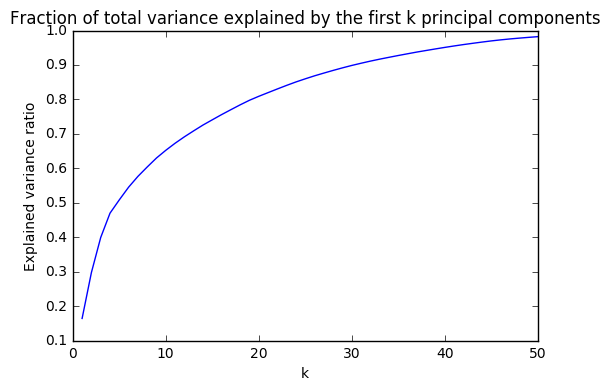

In [5]:
def P1():
    pca = PCA(n_components=50)
    pca.fit(train_data)
    #use cumsum to return the cumulative sum of the elements
    cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(np.arange(1,51),cumulative_ratio[0:50])
    plt.ylabel('Explained variance ratio') 
    plt.xlabel('k')
    plt.title('Fraction of total variance explained by the first k principal components')  
    plt.show() 
P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

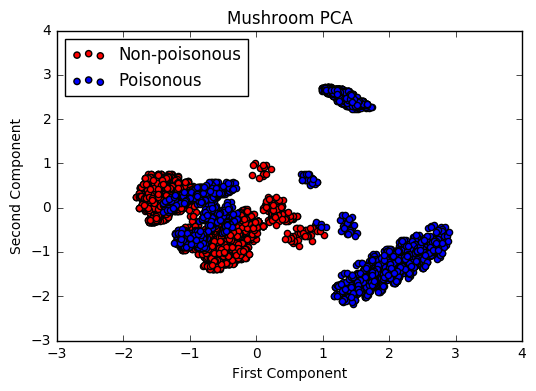

In [104]:
def P2():
    #Project the training data down to 2 dimensions 
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(train_data)

    plt.scatter(transformed_data[:,0][train_labels==0], transformed_data[:,1][train_labels==0], c='r', label='Non-poisonous')
    plt.scatter(transformed_data[:,0][train_labels==1], transformed_data[:,1][train_labels==1], c='b', label='Poisonous')

    plt.ylabel('Second Component') 
    plt.xlabel('First Component')
    plt.title('Mushroom PCA') 
    plt.legend(loc=2)
    plt.show() 
    
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

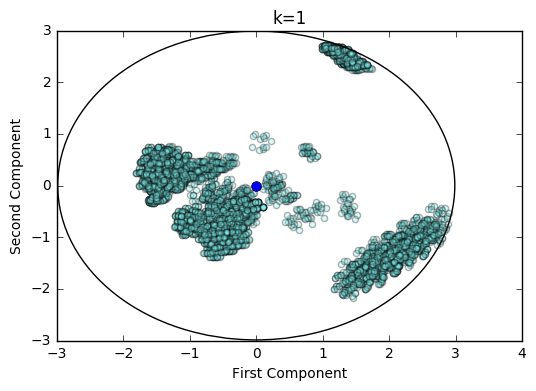

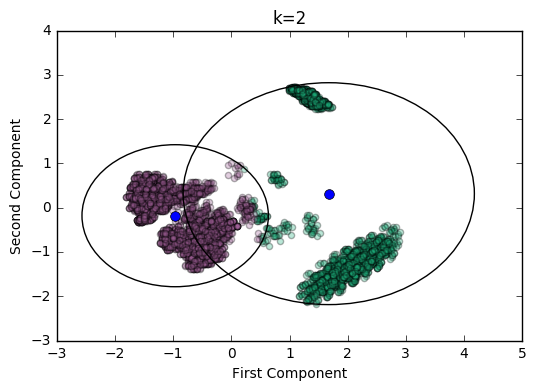

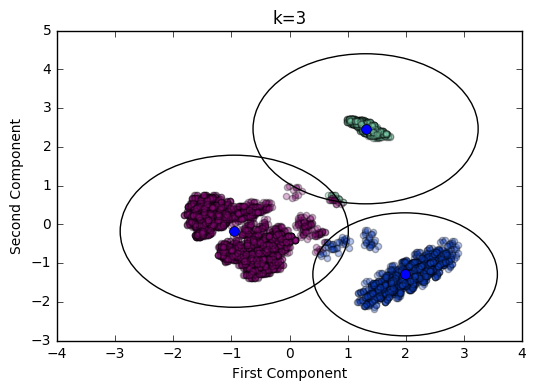

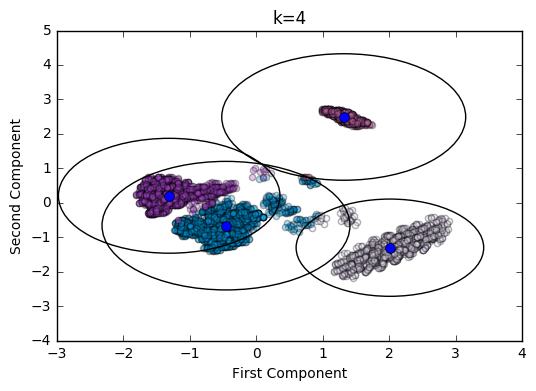

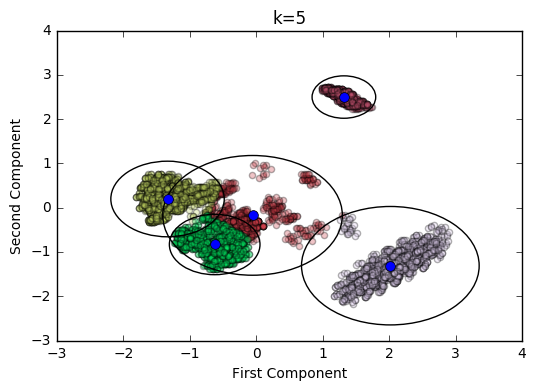

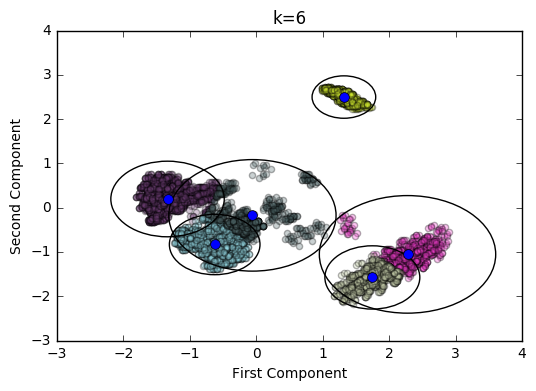

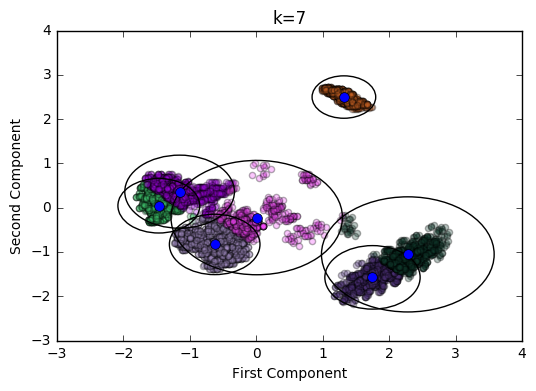

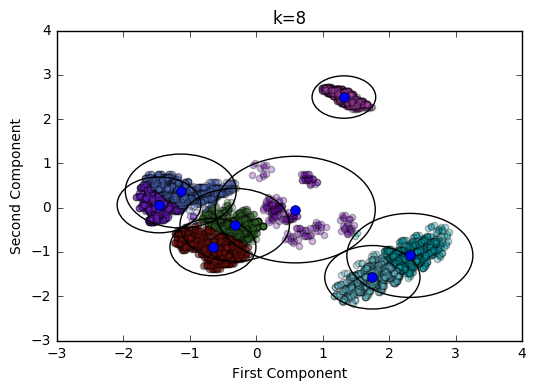

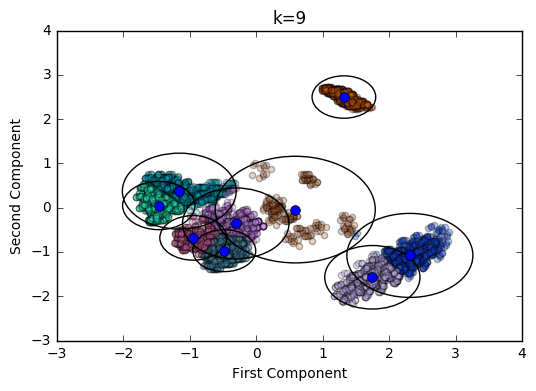

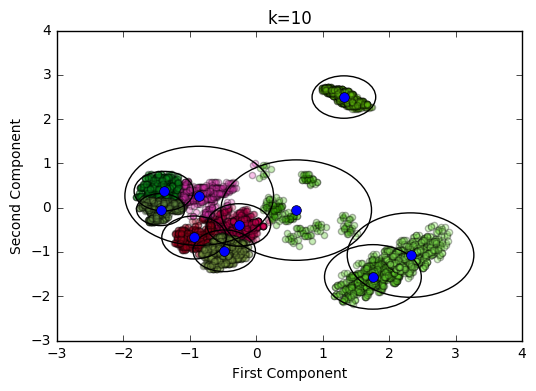

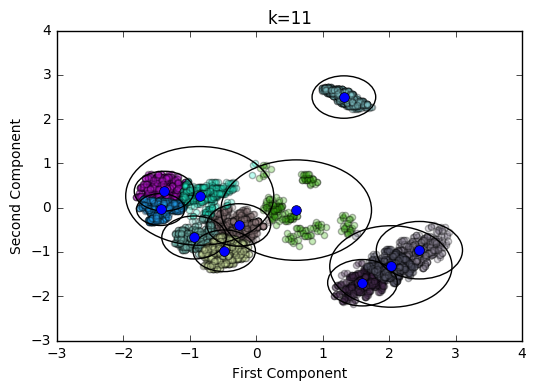

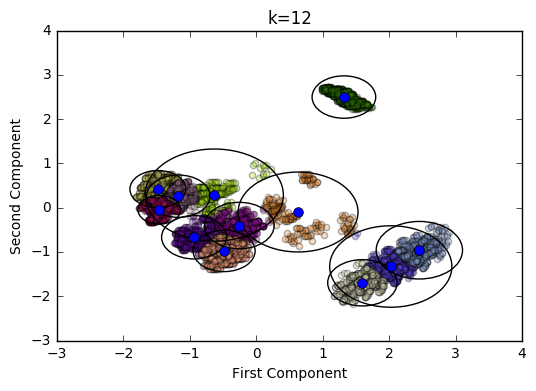

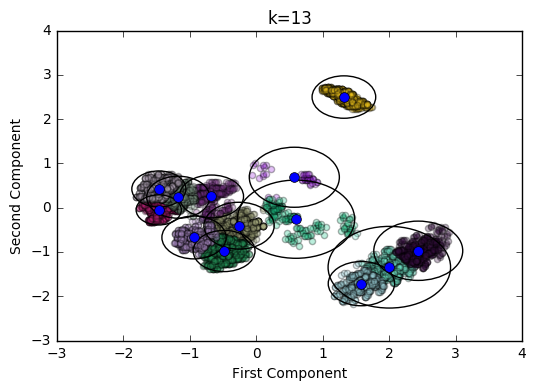

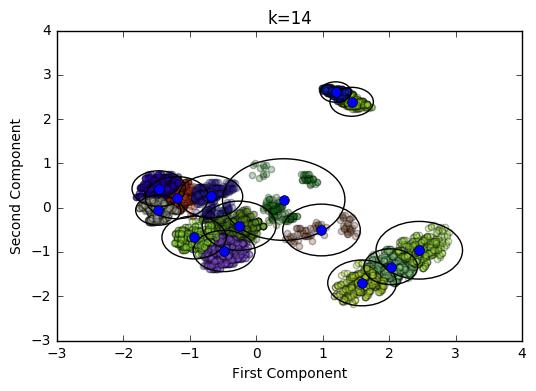

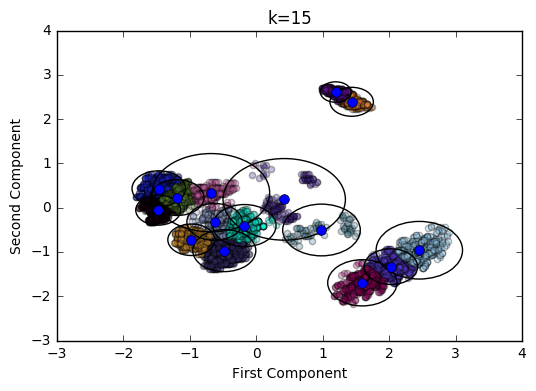

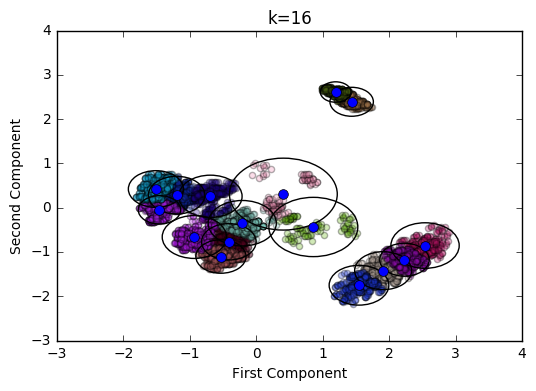

In [30]:
def P3():
    #make the same 2d projected data
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(train_data)
    for cluster in range(1,17):
        #Use fit_transform(X[, y]) - Compute clustering and transform X to cluster-distance space.
        km = KMeans(n_clusters=cluster, init='k-means++')
        distance = km.fit_transform(pca_data)
        # Loop over each cluster center
        for index, center in enumerate(km.cluster_centers_):
            plt.scatter(pca_data[:, 0][km.labels_==index], pca_data[:, 1][km.labels_==index], c=np.random.rand(3,1), alpha=0.3)
            # Plot cluster center with blue circle
            plt.plot(center[0], center[1], 'bo', markersize=7)
            
            # distance of points that correspond to the current cluster 
            distance_subset = distance[km.labels_==index]
            # find the maximium distance
            max_dist = np.amax(distance_subset[:, index])        
            # Plot a circle with radius of max_dist at the cluster center
            circle = plt.Circle(center, max_dist, fill=False)
            plt.gca().add_patch(circle)
        plt.ylabel('Second Component') 
        plt.xlabel('First Component')
        plt.title('k='+ str(cluster)) 
        plt.legend(loc=4)
        plt.show() 


P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

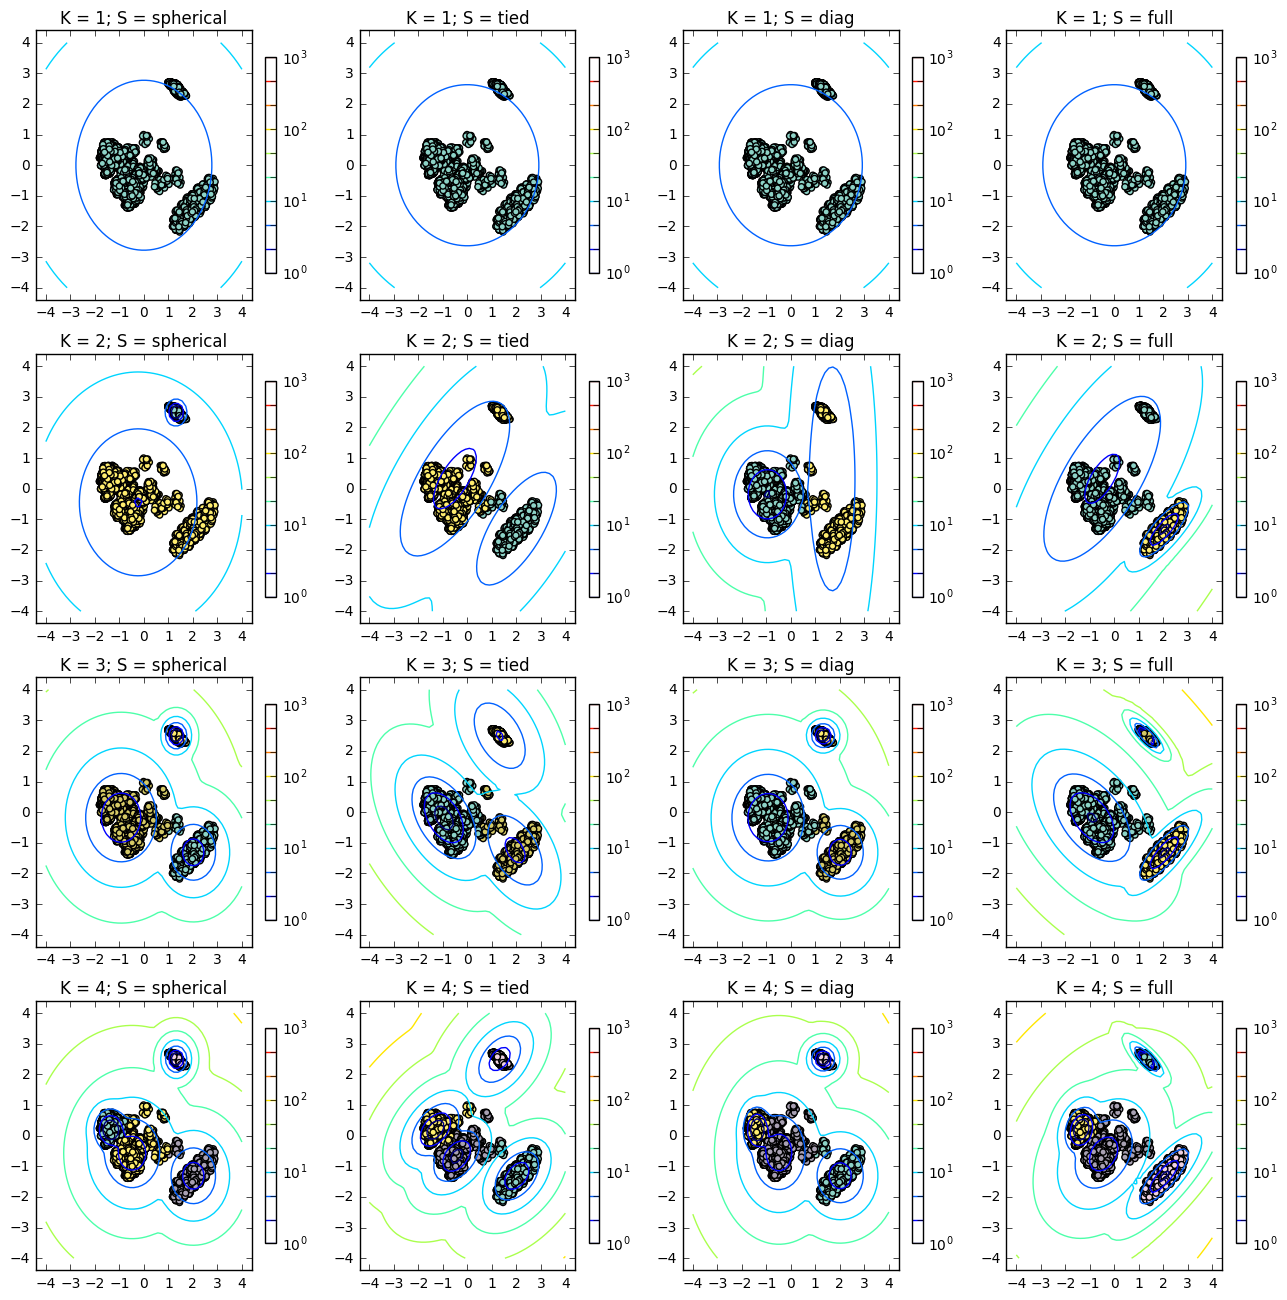

In [105]:
def P4():
    #make the same 2d projected data
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(train_data)
      
    comps = [1,2,3,4]
    structures = ['spherical', 'tied', 'diag', 'full']
    #colormap so we can plot multiple component models
    cm = plt.cm.get_cmap('Set3')
    plt.figure(figsize=(16, 16))
    i = 0

    for comp in comps:
        for structure in structures:
            i += 1

            gm = GaussianMixture(n_components = comp, covariance_type = structure)
            p = plt.subplot(len(comps), len(structures), i)

            gm.fit(pca_data)
            y_pred = gm.predict(pca_data)

            p.scatter(pca_data[:, 0], pca_data[:, 1], c=y_pred, cmap=cm)
            
            # display predicted scores by the model as a contour plot
            # following the documentation given above
            x = np.linspace(-4., 4.)
            y = np.linspace(-4., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            
            plt.title("K = " + str(comp) + "; S = " + str(structure) )


P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [51]:
def P5():
    #make the same 2d projected data
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)
    
    #4-component full covariance GMMs
    gm_pos = GaussianMixture(n_components = 4, covariance_type = 'full')
    gm_pos.fit(pca_data[train_labels==1])
    gm_neg = GaussianMixture(n_components = 4, covariance_type = 'full')
    gm_neg.fit(pca_data[train_labels==0])
    
    # score_samples = Compute the weighted log probabilities for each sample.
    prob_pos = gm_pos.score_samples(pca_test)
    prob_neg = gm_neg.score_samples(pca_test)
    # Predict the type of mushroom after comparing probabilities
    pred = prob_pos >= prob_neg
    accuracy = 1. * (pred == test_labels).sum() / len(test_labels)
    print "Accuracy is", accuracy

P5()

Accuracy is 0.950177935943


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

From the documentation:

'full' = each component has its own general covariance matrix.

'tied' = all components share the same general covariance matrix.

'diag' = each component has its own diagonal covariance matrix.

'spherical' = each component has its own single variance.



In [100]:
def P6():
    pca_comps = np.arange(1,25)
    gmm_comps = np.arange(1,25)
    structures = ['spherical', 'tied', 'diag', 'full']

    parameter_list = []
    accuracy_list = []
    pca_comp_list = []
    gmm_comp_list = []
    structure_list = []
    
    for pca_comp in pca_comps:
        for gmm_comp in gmm_comps:
            for structure in structures:                
                if structure=='diag':
                    #each component would have an i parameter covariance matrix
                    cov_comp = pca_comp
                elif structure == 'full':
                    cov_comp = pca_comp**2
                elif structure == 'tied':   
                    cov_comp = 0.5 * pca_comp *  (pca_comp+1)
                elif structure == 'spherical':
                     #one parameter per covariance matrix and one covariance matrix per GMM component
                    cov_comp = 1;
                # Total number of parameters based on the equation in the question above
                total_params = (pca_comp + cov_comp) * gmm_comp * 2
                
                # Only run code if total number of parameters is less than 50
                if total_params > 50:
                    pass
                else:
                    pca = PCA(n_components=pca_comp)

                    pca_data = pca.fit_transform(train_data)
                    pca_test = pca.transform(test_data)

                    gm_pos = GaussianMixture(n_components = gmm_comp, covariance_type = structure)
                    gm_pos.fit(pca_data[train_labels==1])
                    gm_neg = GaussianMixture(n_components = gmm_comp, covariance_type = structure)
                    gm_neg.fit(pca_data[train_labels==0])
                    parameter_list.append(total_params)
                    # score_samples = Compute the weighted log probabilities for each sample.
                    prob_pos = gm_pos.score_samples(pca_test)
                    prob_neg = gm_neg.score_samples(pca_test)
                    # Predict the type of mushroom after comparing probabilities
                    pred = prob_pos >= prob_neg
                    accuracy = 1. * (pred == test_labels).sum() / len(test_labels)
                    accuracy_list.append(accuracy)
                    pca_comp_list.append(pca_comp)
                    gmm_comp_list.append(gmm_comp)
                    structure_list.append(structure)
                    #print "Accuracy is", accuracy, "for PCA Comp =", pca_comp, "GMM Comp =", gmm_comp, "Structure is", structure
    index_list = np.argsort(accuracy_list)
    high_idx = index_list[-1]
    
    print "Maximum Accuracy is ", max(accuracy_list), "with", pca_comp_list[high_idx], "PCA Components and", gmm_comp_list[high_idx], 'GMM Components with', structure_list[high_idx], "structure."

    print "PCA Comp\tGMM Comp\tStructure\tAccuracy"
    print "--------\t--------\t----------\t----------"
    for i in (range(0,len(index_list))):
        print pca_comp_list[index_list[i]],'\t\t',gmm_comp_list[index_list[i]],'\t\t', structure_list[index_list[i]],'\t\t', accuracy_list[index_list[i]]
P6()

Maximum Accuracy is  0.973309608541 with 7 PCA Components and 3 GMM Components with spherical structure.
PCA Comp	GMM Comp	Structure	Accuracy
--------	--------	----------	----------
4 		1 		tied 		0.816725978648
4 		1 		full 		0.816725978648
3 		2 		full 		0.818505338078
4 		1 		diag 		0.843416370107
1 		1 		spherical 		0.844306049822
1 		1 		tied 		0.844306049822
1 		1 		diag 		0.844306049822
1 		1 		full 		0.844306049822
4 		2 		spherical 		0.853202846975
3 		2 		tied 		0.854982206406
4 		2 		diag 		0.855871886121
3 		2 		diag 		0.859430604982
2 		1 		spherical 		0.860320284698
2 		1 		tied 		0.862099644128
2 		1 		diag 		0.862099644128
2 		1 		full 		0.862099644128
4 		1 		spherical 		0.862989323843
3 		1 		full 		0.865658362989
3 		1 		tied 		0.865658362989
3 		2 		spherical 		0.868327402135
3 		1 		diag 		0.869217081851
5 		1 		spherical 		0.871886120996
3 		1 		spherical 		0.871886120996
8 		1 		spherical 		0.874555160142
9 		1 		spherical 		0.875444839858
2 		2 		spherical 		0.8

Answer:
    
   Both Sphericdal structure, 5 PCA Component with 4 GMM Component and 7 PCA Component with 3 GMM Component give the same highest accuracy score.